### Path setup & Libraries :

In [1]:
project_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF'


In [2]:
lib_path = project_path+'\libraries'
port_path = project_path + '\Data\portfolio'
zc_curve_path = project_path+'\Data\ZC Curve'
diff_path = project_path + '\Data\Diffusion'
MC_path =  project_path +'\Results\Full MC'
img_path = project_path +'\Results\Images'

In [3]:
import numpy as np
import pandas as pd

import  numpy as np

import pickle
from time import time
from datetime import timedelta

from PIL import Image
import matplotlib.pyplot as plt

# importing pacakge 
import sys         
sys.path.append(lib_path)        
from main import *
from FinancialData import *

## Data extraction :

In [4]:
ZCR = ZC_Data_extractor(zc_curve_path)
ZC = zero_coupon_bonds(ZCR, 3) # We chose 3 as degree of the Spline Interpolation 

nbr_fx =  10
nbr_swap = 400
portfolio = Multi_FX_irs_portfolio( nbr_fx, nbr_swap)

#load portfolio data
portfolio.reset_portfolio_from_excel(port_path, '\port400irs10fx.xlsx')

T = portfolio.last_maturity

In [5]:
portfolio.irs_specs

array([(0., 0.25,  60000., 0.04473561, 2.5, 'reciver', 0),
       (0., 0.25,  90000., 0.0495388 , 1. , 'payer', 2),
       (0., 0.25,  80000., 0.04679434, 1. , 'payer', 4),
       (0., 0.5 ,  40000., 0.02958941, 7. , 'payer', 2),
       (0., 1.  , 100000., 0.0377977 , 6.5, 'reciver', 5),
       (0., 1.  ,  30000., 0.02586477, 4.5, 'reciver', 1),
       (0., 1.  ,  10000., 0.0458065 , 2. , 'reciver', 4),
       (0., 0.5 ,  40000., 0.04592901, 2. , 'payer', 0),
       (0., 1.  ,  20000., 0.02235853, 6.5, 'payer', 3),
       (0., 0.25, 100000., 0.04150736, 2. , 'reciver', 0),
       (0., 0.25, 100000., 0.04176027, 4. , 'payer', 6),
       (0., 0.25,  80000., 0.04205143, 3. , 'reciver', 2),
       (0., 0.5 ,  90000., 0.04384751, 3. , 'payer', 9),
       (0., 0.25, 100000., 0.03102544, 3. , 'payer', 4),
       (0., 0.25,  90000., 0.04814816, 5.5, 'payer', 8),
       (0., 0.5 ,  90000., 0.03369468, 1. , 'payer', 1),
       (0., 0.25,  60000., 0.04944313, 7. , 'reciver', 0),
       (0., 1.  ,

In [6]:
#load diffusion data
with open(diff_path+'\MC10000p400s10f', 'rb') as f1:
    diffusion = pickle.load(f1)

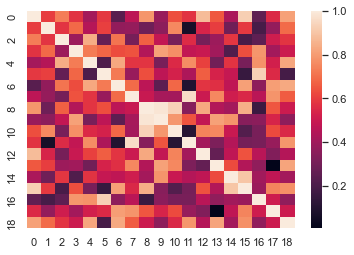

In [7]:
cov = diffusion.covariance_matrix

import seaborn as sns
 
#plotting the heatmap for correlation
ax = sns.heatmap(cov)

In [8]:
#load MC data
with open(MC_path+'\EE_MC_P400sf10', 'rb') as f1:
    mc_df = pickle.load(f1)
    EE_MC = pickle.load(f1)
mc_df.round(1)



,Nodes Number,Mtm,CVA MC,time
0,50.0,-18473.9,1250.7,110.4
1,100.0,-18473.9,1237.6,215.0
2,300.0,-18473.9,1241.3,669.5
3,500.0,-18473.9,1240.4,1097.1


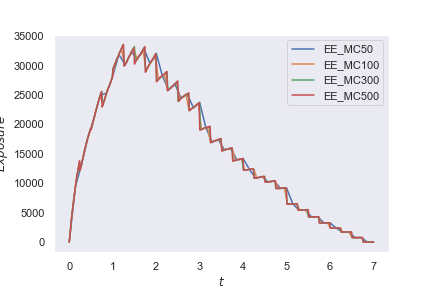

In [9]:
display(Image.open(img_path+'\EE_MC_P600sf10'+'.png'))

      As benchmark we take the full pricing by Monte Carlo using 10000 simulations on 500 time steps wich was calculated in 30 min

In [10]:
def get_synthetic_table(df, idx, mc_df, col_name):
    mtm = mc_df['Mtm'].values[0]

    res = df.copy()

    res['Relative Error'] = df[col_name].apply(lambda x: 1000 * abs(x - mc_df.iloc[idx]['CVA MC']) / abs(mtm))
    res['Speedup Factor'] = df['Computation Time'].apply(lambda x: int(mc_df.iloc[idx]['time'] / x))

    # bq.round(2)
    res = format_table(res)
    if 'Var' in res.columns:
        res.drop(columns='Var')
    if 'Variance' in res.columns:
        res.drop(columns='Variance')

    return format_table(res)[['Training points Number', col_name, 'Relative Error', 'Computation Time', 'Speedup Factor']]

# 1. Interpolation on time :   

## 1.1. CVA by Bayesian Quadrature :

In [11]:
#recovery rate & defult probability parameter :
R, lamda = 0.4, 0.02

time : 10.373871564865112
Nodes numbers 5


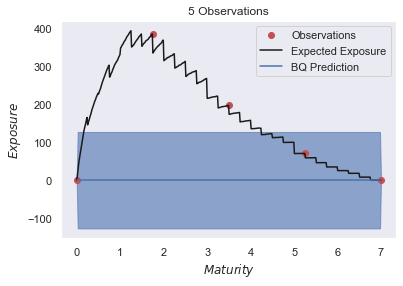

time : 18.003010034561157
Nodes numbers 10


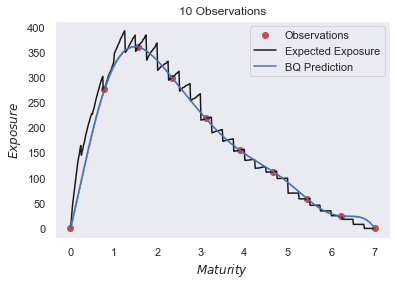

time : 26.978506088256836
Nodes numbers 15


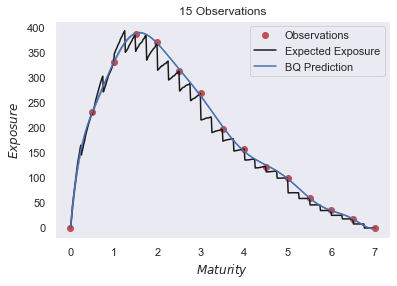

time : 33.69184160232544
Nodes numbers 20


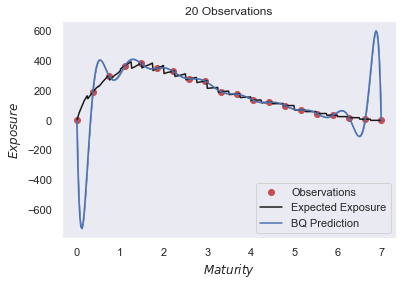

time : 47.40477633476257
Nodes numbers 25


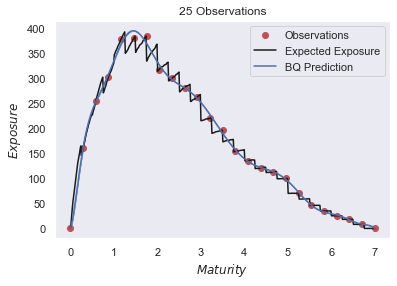

time : 57.5339412689209
Nodes numbers 30


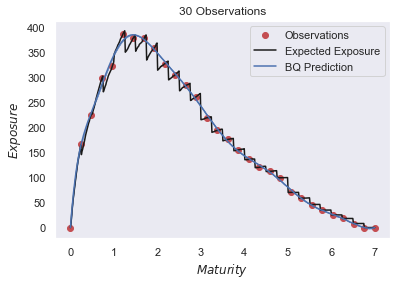

time : 78.05641222000122
Nodes numbers 35


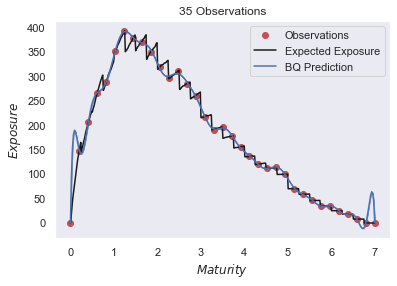

time : 85.27034711837769
Nodes numbers 40


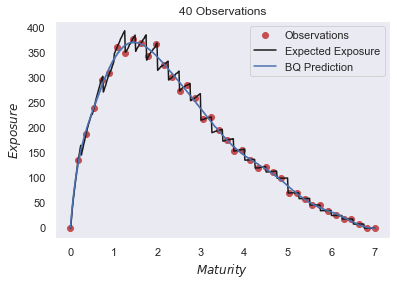

In [12]:

lb , ub = 0,T
x_plot = np.linspace(lb, ub, 300)[:, None]

d = 5
nd = 8

bq_df = pd.DataFrame(columns=['Training points Number','Bayesian Quadrature Prediction', 'Computation Time', 'Variance'])

for i in range(nd):
    start_time = time()
   
    integ_points = np.linspace(0,T,(i+1)*d) 
    
    X = np.array([ [t] for t in integ_points ])
    EE = np.array([ [ Expected_exposure_MC(t, portfolio, diffusion, [ZC for i in range(nbr_fx)]) ] for t in integ_points ])
    PD = np.array([ [lamda * np.exp(-lamda *t)] for t in integ_points ])
    Y = (1-R)*EE*PD
    
    bq = BQ(X,Y, lb, ub)
    
    sec_time =time()-start_time
    print('time :', sec_time)
    
    bq_df.loc[len(bq_df)] = [(i+1)*d,bq.integrate()[0] ,sec_time, bq.integrate()[1]]
    
    PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_MC)) ])
    Y_MC = (1-R)*EE_MC*PD_full
    
    mu_plot, var_plot = bq.predict(x_plot)
    
    print('Nodes numbers', (i+1)*d)
    plt.figure()
    plt.plot(X, Y, "ro", markersize=6, label="Observations")
    plt.plot(np.linspace(0,T,len(EE_MC)), Y_MC, "k", label="Expected Exposure")

    plt.plot(x_plot, mu_plot, "C0", label="BQ Prediction")
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

    plt.legend()
    plt.xlabel(r"$Maturity$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title( str((i+1)*d) + ' Observations')
    plt.savefig(img_path+ '/P400F10_BQ'+ str(i)+'.png')
    plt.show()

In [13]:
get_synthetic_table(bq_df, 3, mc_df, 'Bayesian Quadrature Prediction')

,Training points Number,Bayesian Quadrature Prediction,Relative Error,Computation Time,Speedup Factor
0,5,0,67.14,10,105
1,10,1199,2.21,18,60
2,15,1314,4.01,26,40
3,20,1213,1.45,33,32
4,25,1249,0.48,47,23
5,30,1251,0.59,57,19
6,35,1265,1.38,78,14
7,40,1241,0.07,85,12


In [14]:
get_synthetic_table(bq_df, 3, mc_df, 'Bayesian Quadrature Prediction').to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Calculation of CVA using the Bayesian Quadrature method based on the number of training points and the training of the GPR is done based on time maturity.$",  # The caption to appear above the table in the LaTeX document  # A label used for referencing the table within the LaTeX document
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
)

'\\begin{table}[htbp]\n\\caption{Calculation of CVA using the Bayesian Quadrature method based on the number of training points and the training of the GPR is done based on time maturity.$}\n\\begin{tabular}{|l|l|l|l|}\n\\toprule\nTraining points Number & Bayesian Quadrature Prediction & Relative Error & Computation Time & Speedup Factor \\\\\n\\midrule\n5 & 0 & 67.140000 & 10 & 105 \\\\\n10 & 1199 & 2.210000 & 18 & 60 \\\\\n15 & 1314 & 4.010000 & 26 & 40 \\\\\n20 & 1213 & 1.450000 & 33 & 32 \\\\\n25 & 1249 & 0.480000 & 47 & 23 \\\\\n30 & 1251 & 0.590000 & 57 & 19 \\\\\n35 & 1265 & 1.380000 & 78 & 14 \\\\\n40 & 1241 & 0.070000 & 85 & 12 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

In [15]:
# idx = 3
# mtm = mc_df['Mtm'].values[0]

# bq = bq_df.copy()

# bq['Relative Error'] =  bq_df['Bayesian Quadrature'].apply(lambda x: 1000*abs(x - mc_df.iloc[idx]['CVA MC'])/abs(mtm) )
# bq['computation savings'] =  bq_df['Computation Time'].apply(lambda x: int(mc_df.iloc[idx]['time']/x) )

# #bq.round(2)
# format_table(bq).drop(columns='Var')[['Training points Number', 'Bayesian Quadrature', 'Relative Error','Computation Time', 'Speedup Factor']]


where $Relative Error = \frac{|CVA_{predicted} \, - \, CVA_{Benchmark} |}{|MtM_{0}|}$ expressed in point basis

## 1.2. CVA by chebyshev interpolation 

time : 11.850882530212402
Nodes numbers 5


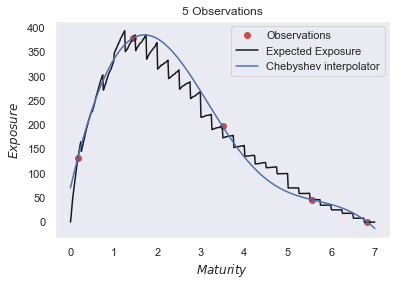

time : 22.468796491622925
Nodes numbers 10


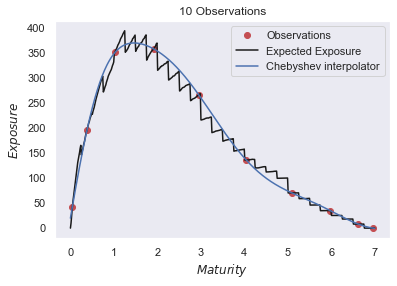

time : 33.66967439651489
Nodes numbers 15


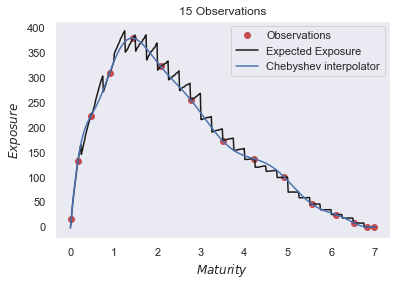

time : 45.10999822616577
Nodes numbers 20


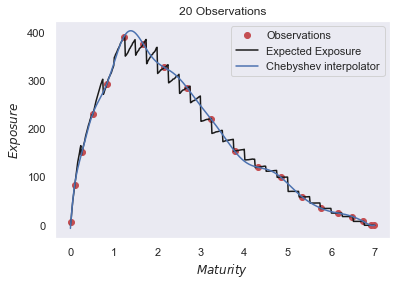

time : 60.57526206970215
Nodes numbers 25


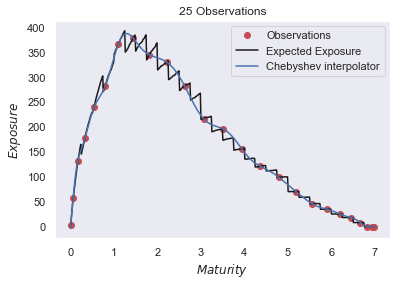

time : 69.95963525772095
Nodes numbers 30


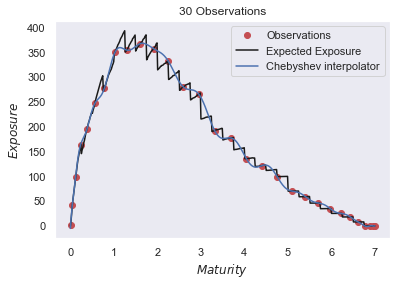

time : 78.46258354187012
Nodes numbers 35


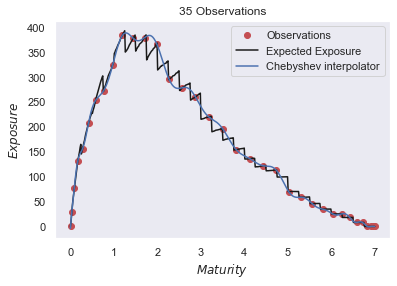

time : 89.67306232452393
Nodes numbers 40


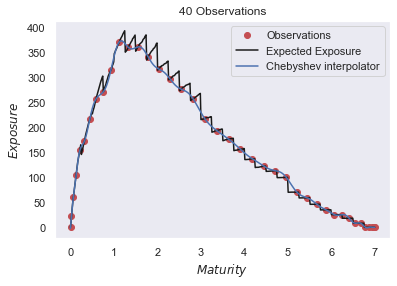

In [16]:

lb , ub = 0,T


integration_grid = np.linspace(0,T,500)
d = 5
nd = 8

cheb_df = pd.DataFrame(columns=['Training points Number','Chebyshev Prediction', 'Computation Time'])

for i in range(nd):
    start_time = time()
   
    integ_points = Chebyshev_points(0, T, (i+1)*d)[::-1]

    EE = np.array([ Expected_exposure_MC(t, portfolio, diffusion, [ZC for i in range(nbr_fx)])  for t in integ_points ])
    PD = np.array([ lamda * np.exp(-lamda *t) for t in integ_points])
    Y = (1-R)*EE*PD
    
    
    EE_cheb = np.array([eval_Barycentric(EE, integ_points, t) for t in integration_grid])
    
    PD = np.array([ lamda * np.exp(-lamda *t) for t in integration_grid ])
    Y_cheb = (1-R)*EE_cheb*PD
    cva = (np.diff(integration_grid)*Y_cheb[1:]).sum()
    
    
    sec_time =time()-start_time
    print('time :', sec_time)
    
    cheb_df.loc[len(cheb_df)] = [(i+1)*d,cva ,sec_time]
    
    PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_MC)) ])
    Y_MC = (1-R)*EE_MC*PD_full
    

    print('Nodes numbers', (i+1)*d)
    plt.figure()
    plt.plot(integ_points, Y, "ro", markersize=6, label="Observations")
    plt.plot(np.linspace(0,T,len(EE_MC)), Y_MC, "k", label="Expected Exposure")

    plt.plot(integration_grid, Y_cheb, "C0", label="Chebyshev interpolator")

    plt.legend()
    plt.xlabel(r"$Maturity$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title( str((i+1)*d) + ' Observations')
    plt.savefig(img_path+ '/P400F10_Chebyshev'+ str(i)+'.png')
    plt.show()

In [17]:
# cheb = cheb_df.copy()
# cheb['Relative_Error %'] = cheb_df['Chebyshev'].apply(lambda x: 100*abs(x - mc_df.iloc[idx]['CVA MC'] )/mc_df.iloc[idx]['CVA MC'] )
# cheb['Error per Mtm'] =  cheb_df['Chebyshev'].apply(lambda x: 1000*abs(x - mc_df.iloc[idx]['CVA MC'] )/abs(mtm) )
# cheb['Time Reduction'] =  cheb_df['time'].apply(lambda x: int(mc_df.iloc[idx]['time']/x) )
# cheb.round(2)

get_synthetic_table(cheb_df, 3, mc_df, 'Chebyshev Prediction')

,Training points Number,Chebyshev Prediction,Relative Error,Computation Time,Speedup Factor
0,5,1279,2.10,11,92
1,10,1262,1.20,22,48
2,15,1221,1.05,33,32
3,20,1250,0.55,45,24
4,25,1241,0.06,60,18
5,30,1244,0.25,69,15
6,35,1245,0.29,78,13
7,40,1222,0.94,89,12


In [18]:
get_synthetic_table(cheb_df, 3, mc_df, 'Chebyshev Prediction').to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Calculation of CVA using the Chebyshev interpolation based on the number of training points on time maturity.",  # The caption to appear above the table in the LaTeX document  # A label used for referencing the table within the LaTeX document
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
)


'\\begin{table}[htbp]\n\\caption{Calculation of CVA using the Chebyshev interpolation based on the number of training points on time maturity.}\n\\begin{tabular}{|l|l|l|l|}\n\\toprule\nTraining points Number & Chebyshev Prediction & Relative Error & Computation Time & Speedup Factor \\\\\n\\midrule\n5 & 1279 & 2.100000 & 11 & 92 \\\\\n10 & 1262 & 1.200000 & 22 & 48 \\\\\n15 & 1221 & 1.050000 & 33 & 32 \\\\\n20 & 1250 & 0.550000 & 45 & 24 \\\\\n25 & 1241 & 0.060000 & 60 & 18 \\\\\n30 & 1244 & 0.250000 & 69 & 15 \\\\\n35 & 1245 & 0.290000 & 78 & 13 \\\\\n40 & 1222 & 0.940000 & 89 & 12 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

    We observe that Chebyshev interploartor fit better the Expected exposure than the GPR in the same cost approximately : 1 to 4 min. However, BQ estimates better the CVA value ! 

- We suggest the following explication :

      In fact Chebyshev convergence properties are well etablished for smooth functions (Continously differentiable or analytic). In the other hand, we have convergence properties for more irregular functions (Sobolev functions) in the framework of Bayesian Quadrature or GPR.
      
      In this study case the Expected exposure is not somooth enough to expect good results from Chebychev interpolator ! Howver bayesian quadrartue can infer better the targeted CVA.

## 2. Interpolation on risk factors :

     We use here the same method for time interpolation (BQ for example) in order to compare the performance of BQ and Chebyshev interpolation when they are used to build a proxy of the Mark-to-market as function of risk factors 

    We chose the number of training point to be 10 for GPR and 5 for Chebyshev ! 
    ( We tested different values and 15 for each method seem to perform in accuracy/spped )


In [19]:
train_size_on_x = 5

time : 4.3530592918396
Nodes numbers 5


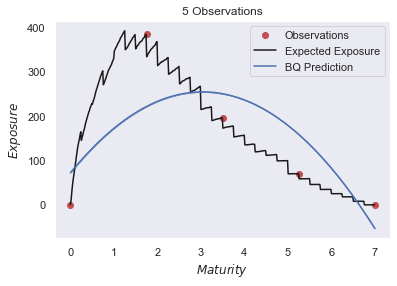

time : 11.31188154220581
Nodes numbers 10


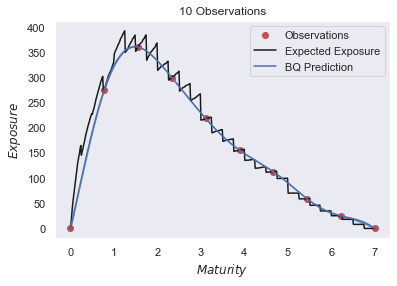

time : 19.460193872451782
Nodes numbers 15


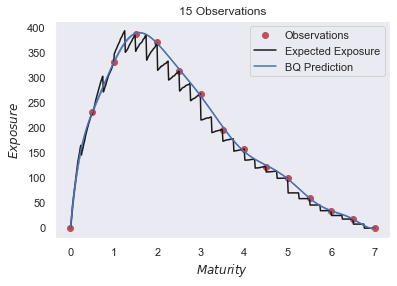

time : 25.49374532699585
Nodes numbers 20


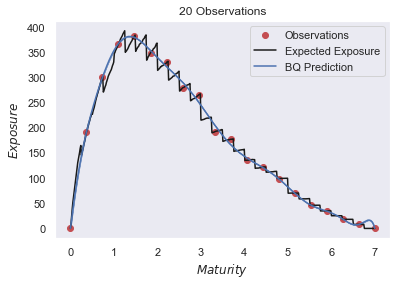

time : 34.69814348220825
Nodes numbers 25


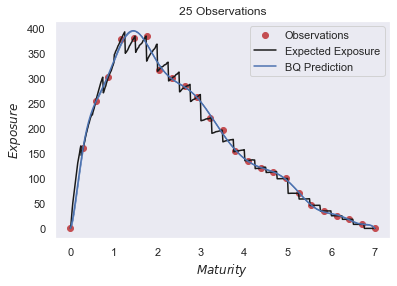

time : 42.686450481414795
Nodes numbers 30


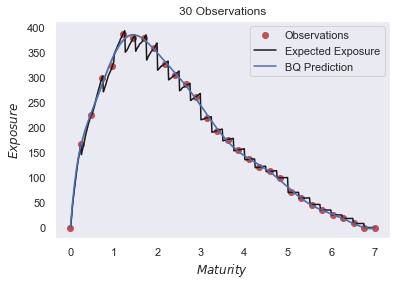

time : 49.73754835128784
Nodes numbers 35


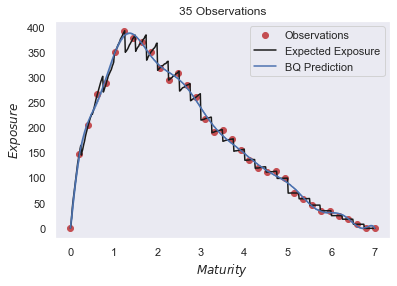

time : 57.83208107948303
Nodes numbers 40


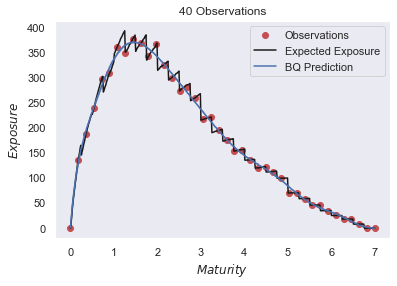

In [20]:
d = 5
nd = 8

bqgp_df = pd.DataFrame(columns=['Training points Number','Bayesian Quadrature Prediction', 'Computation Time', 'Variance'])

for i in range(nd):
    start_time = time()
   
    integ_points = np.linspace(0,T,(i+1)*d) 
    
    X = np.array([ [t] for t in integ_points ])
    EE = np.array([ [ Expected_exposure_MC(t, portfolio, diffusion, [ZC for i in range(nbr_fx)], GPR=True, train_size=train_size_on_x) ] if t>0 else [0] for t in integ_points ])
    PD = np.array([ [lamda * np.exp(-lamda *t)] for t in integ_points ])
    Y = (1-R)*EE*PD
    
    bq = BQ(X,Y, lb, ub)
    
    sec_time =time()-start_time
    print('time :', sec_time)
    
    bqgp_df.loc[len(bqgp_df)] = [(i+1)*d,bq.integrate()[0] ,sec_time, bq.integrate()[1]]
    
    PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_MC)) ])
    Y_MC = (1-R)*EE_MC*PD_full
    
    mu_plot, var_plot = bq.predict(x_plot)
    
    print('Nodes numbers', (i+1)*d)
    plt.figure()
    plt.plot(X, Y, "ro", markersize=6, label="Observations")
    plt.plot(np.linspace(0,T,len(EE_MC)), Y_MC, "k", label="Expected Exposure")

    plt.plot(x_plot, mu_plot, "C0", label="BQ Prediction")
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

    plt.legend()
    plt.xlabel(r"$Maturity$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title( str((i+1)*d) + ' Observations')
    plt.savefig(img_path+ '/P400F10_BQ_GPR_MC__trained'+str(train_size_on_x)+'X'+ str(i)+'t'+'.png')
    plt.show()

In [21]:
# bqgp = bqgp_df.copy()
# bqgp['Relative_Error %'] = bqgp_df['BQ-GPR'].apply(lambda x: 100*abs(x - mc_df.iloc[idx]['CVA MC'] )/mc_df.iloc[idx]['CVA MC'] )
# bqgp['Error per Mtm'] =  bqgp_df['BQ-GPR'].apply(lambda x: 1000*abs(x - mc_df.iloc[idx]['CVA MC'])/abs(mtm) )
# bqgp['Time Reduction'] =  bqgp_df['time'].apply(lambda x: int(mc_df.iloc[idx]['time']/x) )

# bqgp.round(2)

get_synthetic_table(bqgp_df, 3, mc_df, 'Bayesian Quadrature Prediction')

,Training points Number,Bayesian Quadrature Prediction,Relative Error,Computation Time,Speedup Factor
0,5,1195,2.45,4,252
1,10,1196,2.35,11,96
2,15,1313,3.98,19,56
3,20,1252,0.64,25,43
4,25,1250,0.53,34,31
5,30,1253,0.73,42,25
6,35,1247,0.38,49,22
7,40,1235,0.29,57,18


In [22]:
get_synthetic_table(bq_df, 3, mc_df, 'Bayesian Quadrature Prediction').to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Calculation of CVA using the Bayesian Quadrature method based on the number of training points and the training of the GPR is done based on time maturity and $X_{t}$",  # The caption to appear above the table in the LaTeX document  # A label used for referencing the table within the LaTeX document
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
)

'\\begin{table}[htbp]\n\\caption{Calculation of CVA using the Bayesian Quadrature method based on the number of training points and the training of the GPR is done based on time maturity and $X_{t}$}\n\\begin{tabular}{|l|l|l|l|}\n\\toprule\nTraining points Number & Bayesian Quadrature Prediction & Relative Error & Computation Time & Speedup Factor \\\\\n\\midrule\n5 & 0 & 67.140000 & 10 & 105 \\\\\n10 & 1199 & 2.210000 & 18 & 60 \\\\\n15 & 1314 & 4.010000 & 26 & 40 \\\\\n20 & 1213 & 1.450000 & 33 & 32 \\\\\n25 & 1249 & 0.480000 & 47 & 23 \\\\\n30 & 1251 & 0.590000 & 57 & 19 \\\\\n35 & 1265 & 1.380000 & 78 & 14 \\\\\n40 & 1241 & 0.070000 & 85 & 12 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

time : 5.445538282394409
Nodds numbers 5


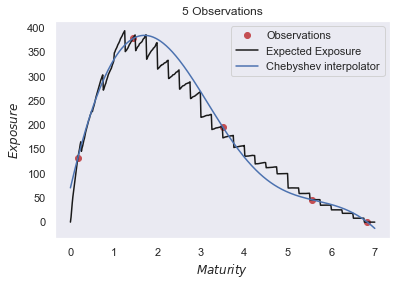

time : 10.1726553440094
Nodds numbers 10


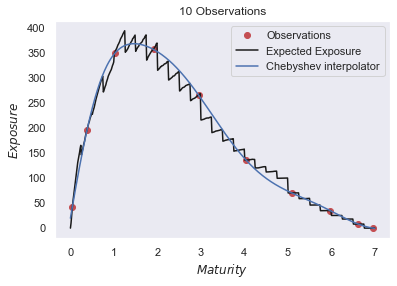

time : 17.058999061584473
Nodds numbers 15


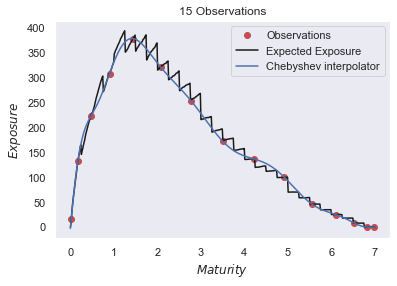

time : 23.616091012954712
Nodds numbers 20


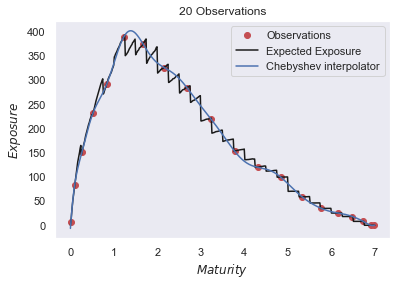

time : 27.57711410522461
Nodds numbers 25


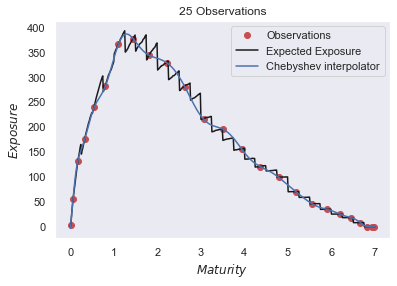

time : 31.81532645225525
Nodds numbers 30


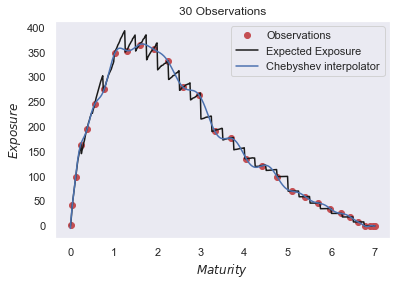

time : 36.810851097106934
Nodds numbers 35


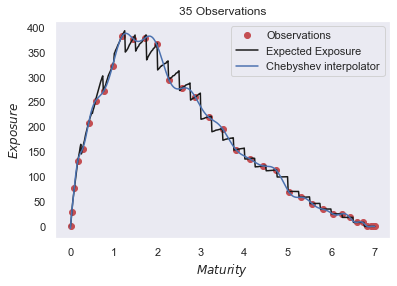

time : 40.39279365539551
Nodds numbers 40


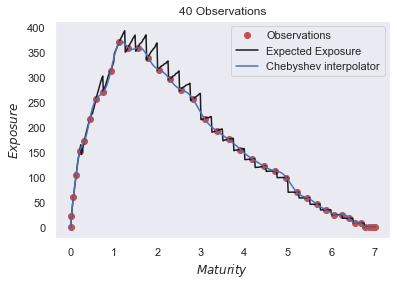

In [23]:
train_size_on_x = 5

integration_grid = np.linspace(0,T,500)
d = 5
nd = 8

cheb2D_df = pd.DataFrame(columns=['Training points Number','Chebyshev Prediction', 'Computation Time'])

for i in range(nd):
    start_time = time()
   
    integ_points = Chebyshev_points(0, T, (i+1)*d)[::-1]

    EE = np.array([ Expected_exposure_MC(t, portfolio, diffusion, [ZC for i in range(nbr_fx)], Chebychev=True, train_size=train_size_on_x)  for t in integ_points ])
    PD = np.array([ lamda * np.exp(-lamda *t) for t in integ_points])
    Y = (1-R)*EE*PD
    
    
    EE_cheb = np.array([eval_Barycentric(EE, integ_points, t) for t in integration_grid])
    
    PD = np.array([ lamda * np.exp(-lamda *t) for t in integration_grid ])
    Y_cheb = (1-R)*EE_cheb*PD
    cva = (np.diff(integration_grid)*Y_cheb[1:]).sum()
    
    
    sec_time =time()-start_time
    print('time :', sec_time)
    
    cheb2D_df.loc[len(cheb2D_df)] = [(i+1)*d,cva ,sec_time]
    
    PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_MC)) ])
    Y_MC = (1-R)*EE_MC*PD_full
    

    print('Nodds numbers', (i+1)*d)
    plt.figure()
    plt.plot(integ_points, Y, "ro", markersize=6, label="Observations")
    plt.plot(np.linspace(0,T,len(EE_MC)), Y_MC, "k", label="Expected Exposure")

    plt.plot(integration_grid, Y_cheb, "C0", label="Chebyshev interpolator")

    plt.legend()
    plt.xlabel(r"$Maturity$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title( str((i+1)*d) + ' Observations')
    plt.savefig(img_path+ '/P400F10_Chebychev_Chebychev_MC_trained'+str(train_size_on_x)+'X'+ str(i)+'t'+'.png')
    plt.show()

In [24]:
# chebcheb = cheb2D_df.copy()
# chebcheb['Relative_Error %'] = cheb2D_df['Chebychev'].apply(lambda x: 100*abs(x - mc_df.iloc[idx]['CVA MC'] )/mc_df.iloc[idx]['CVA MC'] )
# chebcheb['Error per Mtm'] =  cheb2D_df['Chebychev'].apply(lambda x: 1000*abs(x - mc_df.iloc[idx]['CVA MC'])/abs(mtm) )
# chebcheb['Time Reduction'] =  cheb2D_df['time'].apply(lambda x: int(mc_df.iloc[idx]['time']/x) )

# chebcheb.round(2)

get_synthetic_table(cheb2D_df, 3, mc_df, 'Chebyshev Prediction')

,Training points Number,Chebyshev Prediction,Relative Error,Computation Time,Speedup Factor
0,5,1275,1.92,5,201
1,10,1258,0.98,10,107
2,15,1217,1.24,17,64
3,20,1246,0.33,23,46
4,25,1237,0.14,27,39
5,30,1240,0.03,31,34
6,35,1241,0.07,36,29
7,40,1219,1.15,40,27


In [25]:
get_synthetic_table(cheb2D_df, 3, mc_df, 'Chebyshev Prediction').to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Calculation of CVA using two dimensional Chebyshev interpolation based on the number of training points and the training of the GPR is done based on time maturity.$",  # The caption to appear above the table in the LaTeX document  # A label used for referencing the table within the LaTeX document
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
)

'\\begin{table}[htbp]\n\\caption{Calculation of CVA using two dimensional Chebyshev interpolation based on the number of training points and the training of the GPR is done based on time maturity.$}\n\\begin{tabular}{|l|l|l|l|}\n\\toprule\nTraining points Number & Chebyshev Prediction & Relative Error & Computation Time & Speedup Factor \\\\\n\\midrule\n5 & 1275 & 1.920000 & 5 & 201 \\\\\n10 & 1258 & 0.980000 & 10 & 107 \\\\\n15 & 1217 & 1.240000 & 17 & 64 \\\\\n20 & 1246 & 0.330000 & 23 & 46 \\\\\n25 & 1237 & 0.140000 & 27 & 39 \\\\\n30 & 1240 & 0.030000 & 31 & 34 \\\\\n35 & 1241 & 0.070000 & 36 & 29 \\\\\n40 & 1219 & 1.150000 & 40 & 27 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

      By training on risk factor we achive a better performance with the same previous accuracy  

      As we said before, we observe that Bayesian Quadrature estimates better the CVA in the same cost approximately : 20 secoonds to 2 min for a relative error in the order of 1% to 2%  

### Suggestion : 

    Numerical test suggest us to use Chebyshev for the interpolation on risk factor and the Bayesian quadrature for time interpolation unless we expect a smooth exposure (for example a long or short IRS portfolio)

time : 4.484502792358398
Nodes numbers 5


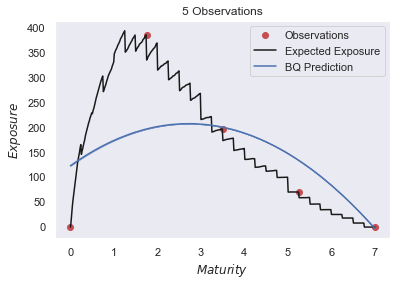

time : 10.730950832366943
Nodes numbers 10


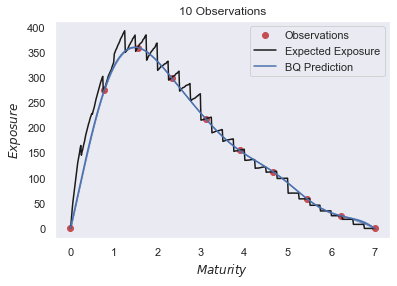

time : 16.44593834877014
Nodes numbers 15


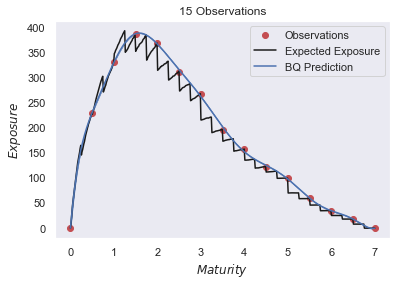

time : 23.092172384262085
Nodes numbers 20


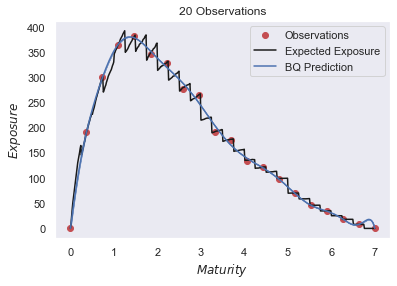

time : 28.20633888244629
Nodes numbers 25


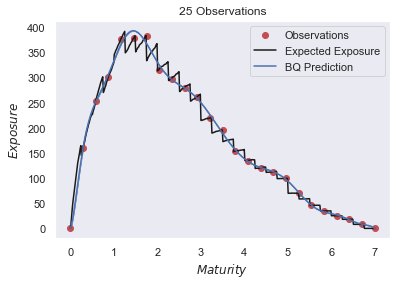

time : 32.28009819984436
Nodes numbers 30


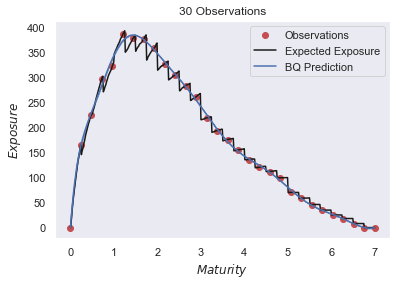

time : 33.889063596725464
Nodes numbers 35


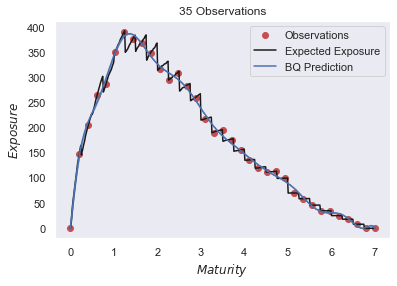

time : 38.677056312561035
Nodes numbers 40


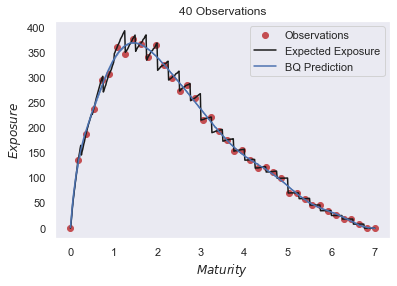

In [26]:
train_size_on_x = 5
d = 5
nd = 8

bqcheb_df = pd.DataFrame(columns=['Training points Number','Bayesian Quadrature Prediction', 'Computation Time', 'Variance'])

for i in range(nd):
    start_time = time()
   
    integ_points = np.linspace(0,T,(i+1)*d) 
    
    X = np.array([ [t] for t in integ_points ])
    EE = np.array([ [ Expected_exposure_MC(t, portfolio, diffusion, [ZC for i in range(nbr_fx)], Chebychev=True, train_size=train_size_on_x) ]  for t in integ_points ])
    PD = np.array([ [lamda * np.exp(-lamda *t)] for t in integ_points ])
    Y = (1-R)*EE*PD
    
    bq = BQ(X,Y, lb, ub)
    
    sec_time =time()-start_time
    print('time :', sec_time)
    
    bqcheb_df.loc[len(bqcheb_df)] = [(i+1)*d,bq.integrate()[0] ,sec_time, bq.integrate()[1]]
    
    PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_MC)) ])
    Y_MC = (1-R)*EE_MC*PD_full
    
    mu_plot, var_plot = bq.predict(x_plot)
    
    print('Nodes numbers', (i+1)*d)
    plt.figure()
    plt.plot(X, Y, "ro", markersize=6, label="Observations")
    plt.plot(np.linspace(0,T,len(EE_MC)), Y_MC, "k", label="Expected Exposure")

    plt.plot(x_plot, mu_plot, "C0", label="BQ Prediction")
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

    plt.legend()
    plt.xlabel(r"$Maturity$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title( str((i+1)*d) + ' Observations')
    plt.savefig(img_path+ '/P600F10_BQ_cheb_MC_trained'+str(train_size_on_x)+'X'+ str(i)+'t'+'.png')
    plt.show()


In [27]:
get_synthetic_table(bqcheb_df, 3, mc_df, 'Bayesian Quadrature Prediction')

,Training points Number,Bayesian Quadrature Prediction,Relative Error,Computation Time,Speedup Factor
0,5,1074,8.99,4,244
1,10,1193,2.54,10,102
2,15,1311,3.82,16,66
3,20,1249,0.47,23,47
4,25,1245,0.27,28,38
5,30,1247,0.39,32,33
6,35,1243,0.19,33,32
7,40,1235,0.27,38,28
